In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

# !ls

In [2]:
import os

home_dir = '/content/gdrive/My Drive/AChina' 
home_dir = '/hy-tmp'
os.chdir(home_dir)
!pwd

!pip install tqdm

from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

/hy-tmp
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


In [3]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

# os.chdir("../../..")

In [4]:
# !pip install torch torchvision
# !pip install pytorch_lightning
# !pip install pytorch_forecasting

# !pip install torch -f https://download.pytorch.org/whl/torch_stable.html
# !pip install pytorch-forecasting

!pip install scipy
!pip install torch pytorch-lightning pytorch_forecasting
!pip install rich

import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAPE, SMAPE, PoissonLoss, QuantileLoss
# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters


Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


In [5]:
data = pd.read_csv('corn_china_pandas_onebands.csv')  # encoding= 'unicode_escape')

data[0:15]

,Unnamed: 0,years,yield,sownareas,yieldvals,county,MODIS,time_idx,band_0_0,band_0_1,...,band_8_502,band_8_503,band_8_504,band_8_505,band_8_506,band_8_507,band_8_508,band_8_509,band_8_510,band_8_511
0,0,2003,0.61295,75.21,46.1,0,MOD_0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2003,0.61295,75.21,46.1,0,MOD_1,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2003,0.61295,75.21,46.1,0,MOD_2,2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2003,0.61295,75.21,46.1,0,MOD_3,3,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2003,0.61295,75.21,46.1,0,MOD_4,4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5,2003,0.61295,75.21,46.1,0,MOD_5,5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,6,2003,0.61295,75.21,46.1,0,MOD_6,6,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7,2003,0.61295,75.21,46.1,0,MOD_7,7,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,8,2003,0.61295,75.21,46.1,0,MOD_8,8,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,9,2003,0.61295,75.21,46.1,0,MOD_9,9,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# mod = ['MOD_' + str(time_idx) for time_idx in data['time_idx']]

# # df = data.copy()

# data.insert(6, "MODIS", mod, True)

# data

# # df

In [7]:
data['years'] = data['years'].astype(str)
data['county'] = data['county'].astype(str)
data['time_idx'] = data['time_idx'].astype(int)
data.head()
# print(type(data['bin500'][0]))

,Unnamed: 0,years,yield,sownareas,yieldvals,county,MODIS,time_idx,band_0_0,band_0_1,...,band_8_502,band_8_503,band_8_504,band_8_505,band_8_506,band_8_507,band_8_508,band_8_509,band_8_510,band_8_511
0,0,2003,0.61295,75.21,46.1,0,MOD_0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2003,0.61295,75.21,46.1,0,MOD_1,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2003,0.61295,75.21,46.1,0,MOD_2,2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2003,0.61295,75.21,46.1,0,MOD_3,3,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2003,0.61295,75.21,46.1,0,MOD_4,4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
data.describe()

,Unnamed: 0,yield,sownareas,yieldvals,time_idx,band_0_0,band_0_1,band_0_2,band_0_3,band_0_4,...,band_8_502,band_8_503,band_8_504,band_8_505,band_8_506,band_8_507,band_8_508,band_8_509,band_8_510,band_8_511
count,10208.000000,10208.000000,10208.000000,10208.000000,10208.000000,10208.000000,10208.000000,10208.000000,10208.000000,10208.000000,...,1.020800e+04,1.020800e+04,1.020800e+04,1.020800e+04,1.020800e+04,1.020800e+04,1.020800e+04,1.020800e+04,1.020800e+04,1.020800e+04
mean,463.500000,0.517953,1054.189060,564.198213,15.500000,0.000159,0.000013,0.000014,0.000015,0.000017,...,2.092016e-07,2.026622e-07,2.181514e-07,1.555445e-07,1.194250e-07,1.453146e-07,1.647957e-07,2.702309e-07,1.788296e-07,5.195724e-08
std,267.903492,0.106656,1126.135219,659.836500,9.233545,0.000836,0.000086,0.000073,0.000077,0.000096,...,8.246547e-06,6.370645e-06,9.220619e-06,5.313741e-06,3.498986e-06,5.891810e-06,5.659541e-06,1.296903e-05,1.033253e-05,1.870616e-06
min,0.000000,0.276526,1.810000,1.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,231.750000,0.438383,192.340000,116.940000,7.750000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,463.500000,0.518895,577.010000,263.520000,15.500000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,695.250000,0.574336,1559.340000,736.100000,23.250000,0.000041,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,927.000000,0.855448,4210.460000,2662.150000,31.000000,0.034574,0.005399,0.002629,0.002457,0.004608,...,7.321716e-04,4.791045e-04,7.695267e-04,3.547672e-04,2.012576e-04,5.226595e-04,2.943380e-04,1.221001e-03,1.013905e-03,1.319261e-04


In [9]:
import torch
from torch import nn

class FullyConnectedModule(nn.Module):
    def __init__(self, input_size: int, output_size: int, hidden_size: int, n_hidden_layers: int):
        super().__init__()

        # input layer
        module_list = [nn.Linear(input_size, hidden_size), nn.ReLU()]
        # hidden layers
        for _ in range(n_hidden_layers):
            module_list.extend([nn.Linear(hidden_size, hidden_size), nn.ReLU()])
        # output layer
        module_list.append(nn.Linear(hidden_size, output_size))

        self.sequential = nn.Sequential(*module_list)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x of shape: batch_size x n_timesteps_in
        # output of shape batch_size x n_timesteps_out
        return self.sequential(x)


# test that network works as intended
network = FullyConnectedModule(input_size=5, output_size=2, hidden_size=10, n_hidden_layers=2)
x = torch.rand(20, 5)
network(x).shape


torch.Size([20, 2])

In [10]:
from typing import Dict, List, Tuple
from pytorch_forecasting.models.nn import MultiEmbedding
from pytorch_forecasting.models import BaseModelWithCovariates

class FullyConnectedModelWithCovariates(BaseModelWithCovariates):
    def __init__(
        self,
        input_size: int,
        output_size: int,
        hidden_size: int,
        n_hidden_layers: int,
        x_reals: List[str],
        x_categoricals: List[str],
        embedding_sizes: Dict[str, Tuple[int, int]],
        embedding_labels: Dict[str, List[str]],
        static_categoricals: List[str],
        static_reals: List[str],
        time_varying_categoricals_encoder: List[str],
        time_varying_categoricals_decoder: List[str],
        time_varying_reals_encoder: List[str],
        time_varying_reals_decoder: List[str],
        embedding_paddings: List[str],
        categorical_groups: Dict[str, List[str]],
        **kwargs,
    ):
        # saves arguments in signature to `.hparams` attribute, mandatory call - do not skip this
        self.save_hyperparameters()
        # pass additional arguments to BaseModel.__init__, mandatory call - do not skip this
        super().__init__(**kwargs)

        # create embedder - can be fed with x["encoder_cat"] or x["decoder_cat"] and will return
        # dictionary of category names mapped to embeddings
        self.input_embeddings = MultiEmbedding(
            embedding_sizes=self.hparams.embedding_sizes,
            categorical_groups=self.hparams.categorical_groups,
            embedding_paddings=self.hparams.embedding_paddings,
            x_categoricals=self.hparams.x_categoricals,
            max_embedding_size=self.hparams.hidden_size,
        )
        
        # calculate the size of all concatenated embeddings + continous variables
        n_features = sum(
            embedding_size for classes_size, embedding_size in self.hparams.embedding_sizes.values()
        ) + len(self.reals)

        # create network that will be fed with continious variables and embeddings
        self.network = FullyConnectedModule(
            input_size=self.hparams.input_size * n_features,
            output_size=self.hparams.output_size,
            hidden_size=self.hparams.hidden_size,
            n_hidden_layers=self.hparams.n_hidden_layers,
        )

    def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        # x is a batch generated based on the TimeSeriesDataset
        batch_size = x["encoder_lengths"].size(0)
        embeddings = self.input_embeddings(x["encoder_cat"])  # returns dictionary with embedding tensors
        network_input = torch.cat(
            [x["encoder_cont"]]
            + [
                emb
                for name, emb in embeddings.items()
                if name in self.encoder_variables or name in self.static_variables
            ],
            dim=-1,
        )
        prediction = self.network(network_input.view(batch_size, -1))

        # rescale predictions into target space
        prediction = self.transform_output(prediction, target_scale=x["target_scale"])

        # We need to return a dictionary that at least contains the prediction.
        # The parameter can be directly forwarded from the input.
        # The conversion to a named tuple can be directly achieved with the `to_network_output` function.
        return self.to_network_output(prediction=prediction)
    
    @classmethod
    def from_dataset(cls, dataset: TimeSeriesDataSet, **kwargs):
        new_kwargs = {
            "output_size": dataset.max_prediction_length,
            "input_size": dataset.max_encoder_length,
        }
        new_kwargs.update(kwargs)  # use to pass real hyperparameters and override defaults set by dataset
        # example for dataset validation
        assert dataset.max_prediction_length == dataset.min_prediction_length, "Decoder only supports a fixed length"
        assert dataset.min_encoder_length == dataset.max_encoder_length, "Encoder only supports a fixed length"

        return super().from_dataset(dataset, **new_kwargs)
    

In [11]:
from pytorch_lightning.utilities.model_summary import summarize
from pytorch_forecasting.metrics import MAE, RMSE

# create the dataset from the pandas dataframe
train_data = data[ data["years"] != "2018" ]
valid_data = data[ data["years"] == "2018" ]

bins_name = list()   #list(["yield"])
for bin in range(0, 512):
    bins_name.append(f'bin{bin}')

# print(bins_name)  

bins_name = list()
for band in tqdm(range(0, 9)):
    for bins in range(0, 512):
        bins_name.append( f'band_{band}_{bins}' )

encoder_length = 18
group=["years", "county"]
unknown_categoricals=["years", "county", "bands"]
static_categoricals=["years", "county"]
known_reals=["sownareas"]

train_dataset_with_covariates = TimeSeriesDataSet(
    train_data,
    group_ids=group,
    target="yield",
    time_idx="time_idx",
    min_encoder_length=encoder_length,
    max_encoder_length=encoder_length,
    min_prediction_length=1,
    max_prediction_length=1,
    time_varying_unknown_reals=bins_name,  #["yield"],
    # time_varying_unknown_categoricals=unknown_categoricals,
    # time_varying_known_reals=known_reals,
    # time_varying_known_categoricals=["years", "county"],
    # static_categoricals=static_categoricals,
    # allow_missing_timesteps=True,
)

valid_dataset_with_covariates = TimeSeriesDataSet(
    valid_data,
    group_ids=group,
    target="yield",
    time_idx="time_idx",
    min_encoder_length=encoder_length,
    max_encoder_length=encoder_length,
    min_prediction_length=1,
    max_prediction_length=1,
    time_varying_unknown_reals=bins_name,   #["yield"],
    # time_varying_unknown_categoricals=unknown_categoricals,
    # time_varying_known_reals=known_reals,
    # time_varying_known_categoricals=["years", "county"],
    # static_categoricals=static_categoricals,
    # allow_missing_timesteps=True,
)

hidden_size=50
n_hidden_layers=8
model = FullyConnectedModelWithCovariates.from_dataset(train_dataset_with_covariates, \
                                                       hidden_size=hidden_size, \
                                                       n_hidden_layers=n_hidden_layers, \
                                                       loss=MAE())
summarize(model,max_depth=-1)  # print model summary
model.hparams


100%|██████████| 9/9 [00:00<00:00, 5109.47it/s]


"categorical_groups":                {}
"embedding_labels":                  {}
"embedding_paddings":                []
"embedding_sizes":                   {}
"hidden_size":                       50
"input_size":                        18
"learning_rate":                     0.001
"log_gradient_flow":                 False
"log_interval":                      -1
"log_val_interval":                  -1
"logging_metrics":                   ModuleList()
"loss":                              MAE()
"monotone_constaints":               {}
"n_hidden_layers":                   8
"optimizer":                         ranger
"optimizer_params":                  None
"output_size":                       1
"output_transformer":                GroupNormalizer(
	method='standard',
	groups=[],
	center=True,
	scale_by_group=False,
	transformation='relu',
	method_kwargs={}
)
"reduce_on_plateau_min_lr":          1e-05
"reduce_on_plateau_patience":        1000
"reduce_on_plateau_reduction":       2.0
"sta

In [12]:
from pytorch_forecasting.metrics import MAE

# model = FullyConnectedModelWithCovariates.from_dataset(train_dataset_with_covariates, 
#                                                        hidden_size=20, n_hidden_layers=5, loss=MAE())

# convert datasets to dataloaders for training
batch_size = 32
train_dataloader = train_dataset_with_covariates.to_dataloader(train=True,  batch_size=batch_size, num_workers=2)
valid_dataloader = valid_dataset_with_covariates.to_dataloader(train=False, batch_size=batch_size, num_workers=2)


In [13]:
# convert the dataset to a dataloader
# dataloader = dataset.to_dataloader(batch_size=4)

# and load the first batch
x, y = next(iter(valid_dataloader))
# print("x =", x)
# print("\ny =", y)
# print("\nsizes of x =")
for key, value in x.items():
    print(f"\t{key} = {value.size()}")

	encoder_cat = torch.Size([32, 18, 0])
	encoder_cont = torch.Size([32, 18, 4608])
	encoder_target = torch.Size([32, 18])
	encoder_lengths = torch.Size([32])
	decoder_cat = torch.Size([32, 1, 0])
	decoder_cont = torch.Size([32, 1, 4608])
	decoder_target = torch.Size([32, 1])
	decoder_lengths = torch.Size([32])
	decoder_time_idx = torch.Size([32, 1])
	groups = torch.Size([32, 2])
	target_scale = torch.Size([32, 2])


In [14]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import TQDMProgressBar
from pytorch_lightning.callbacks import RichProgressBar

logger_name = f"FCNN_2: batch_size={batch_size}, encoder_length={encoder_length}, \
                            group={group}, hidden_size={hidden_size}, n_hidden_layers={n_hidden_layers},\
                            loss=MAE"

logger = TensorBoardLogger('/tf_logs', name=logger_name)

# trainer = Trainer(gpus=1, max_epochs=100, limit_train_batches=2606, logger=logger)
trainer = Trainer(accelerator='gpu', devices=1, logger=logger, max_epochs=35)
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)
# trainer.validate(model=model, dataloaders=valid_dataloaders)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /tf_logs/FCNN_2: batch_size=32, encoder_length=18,                             group=['years', 'county'], hidden_size=50, n_hidden_layers=8,                            loss=MAE
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                 | Params
----------------------------------------------------------
0 | loss             | MAE                  | 0     
1 | logging_metrics  | ModuleList           | 0     
2 | input_embeddings | MultiEmbedding       | 0     
3 | network          | FullyConnectedModule | 4.2 M 
----------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.671    Total estimated model params size (MB)


Epoch 0:  94%|█████████▎| 131/140 [12:56<00:53,  5.93s/it, loss=0.0849, v_num=0, train_loss_step=0.0887]
Validation: 0it [00:00, ?it/s]
Epoch 1:  94%|█████████▎| 131/140 [13:44<00:56,  6.29s/it, loss=0.0833, v_num=0, train_loss_step=0.0752, val_loss=0.0767, train_loss_epoch=0.0847]
Validation: 0it [00:00, ?it/s]
Epoch 2:  94%|█████████▎| 131/140 [14:07<00:58,  6.47s/it, loss=0.0534, v_num=0, train_loss_step=0.0585, val_loss=0.0701, train_loss_epoch=0.0838]
Validation: 0it [00:00, ?it/s]
Epoch 3:  94%|█████████▎| 131/140 [14:53<01:01,  6.82s/it, loss=0.0406, v_num=0, train_loss_step=0.0428, val_loss=0.0565, train_loss_epoch=0.0628]
Validation: 0it [00:00, ?it/s]
Epoch 4:  94%|█████████▎| 131/140 [15:33<01:04,  7.12s/it, loss=0.035, v_num=0, train_loss_step=0.0279, val_loss=0.0442, train_loss_epoch=0.0451] 
Validation: 0it [00:00, ?it/s]
Epoch 6:  94%|█████████▎| 131/140 [15:18<01:03,  7.01s/it, loss=0.0298, v_num=0, train_loss_step=0.0234, val_loss=0.034, train_loss_epoch=0.0322]
Valida

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 140/140 [29:26<00:00, 12.62s/it, loss=0.01, v_num=0, train_loss_step=0.0092, val_loss=0.0332, train_loss_epoch=0.00809]


In [15]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
# best_model_path = trainer.checkpoint_callback.best_model_path
# best_tft = FullyConnectedModelWithCovariates.load_from_checkpoint(best_model_path)
trainer.save_checkpoint("fc_best_model2.ckpt")
best_tft = FullyConnectedModelWithCovariates.load_from_checkpoint("fc_best_model2.ckpt")

In [16]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(valid_dataloader)])
predictions = best_tft.predict(valid_dataloader)
(actuals - predictions).abs().mean()

tensor(0.0332)

In [17]:
print(type(actuals), actuals.shape, type(predictions), predictions.shape)
print(actuals, predictions)

<class 'torch.Tensor'> torch.Size([266, 1]) <class 'torch.Tensor'> torch.Size([266, 1])
tensor([[0.8284],
        [0.8284],
        [0.8284],
        [0.8284],
        [0.8284],
        [0.8284],
        [0.8284],
        [0.8284],
        [0.8284],
        [0.8284],
        [0.8284],
        [0.8284],
        [0.8284],
        [0.8284],
        [0.5919],
        [0.5919],
        [0.5919],
        [0.5919],
        [0.5919],
        [0.5919],
        [0.5919],
        [0.5919],
        [0.5919],
        [0.5919],
        [0.5919],
        [0.5919],
        [0.5919],
        [0.5919],
        [0.5231],
        [0.5231],
        [0.5231],
        [0.5231],
        [0.5231],
        [0.5231],
        [0.5231],
        [0.5231],
        [0.5231],
        [0.5231],
        [0.5231],
        [0.5231],
        [0.5231],
        [0.5231],
        [0.4363],
        [0.4363],
        [0.4363],
        [0.4363],
        [0.4363],
        [0.4363],
        [0.4363],
        [0.4363],
        [0.4

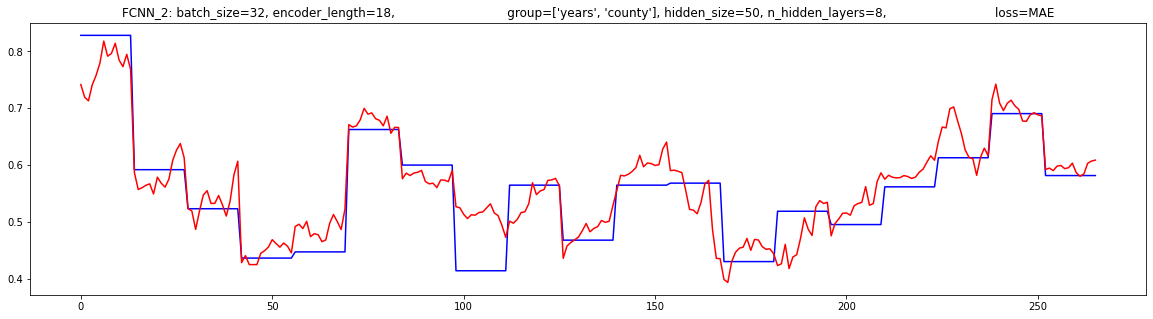

In [18]:
from matplotlib import pyplot as plt

X = [X for X in range(0, actuals.shape[0])]

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20,5))

ax1.plot(X, actuals, color='b', label="Actual")
ax1.plot(X, predictions, color='r', label="Predicted")
ax1.set_title(logger_name)

files = os.path.join(home_dir, f'FCNN_2.png')
plt.savefig(files, bbox_inches='tight')
plt.show()


In [19]:
print(len(actuals))

266


In [20]:
fn

NameError: name 'fn' is not defined

In [ ]:
max_prediction_length = 3
max_encoder_length = 8
training_cutoff = data["time_idx"].max() - max_prediction_length

# print(training_cutoff)
# x = data[lambda x: x.time_idx <= training_cutoff]
# print()

bins_name = list(["yield"])
for bin in range(0, 512):
  bins_name.append(f'bin{bin}')

print(bins_name)

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx = "time_idx",
    target = "yield",
    group_ids = ["county", "bands", "time"],
    min_encoder_length = max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length = max_encoder_length,
    min_prediction_length = 1,
    max_prediction_length = max_prediction_length,
    # static_categoricals = ["county"],
    # static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    # time_varying_known_categoricals=["special_days", "month"],
    # variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    # time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    # time_varying_unknown_categoricals=[],
    time_varying_unknown_reals = bins_name,
    allow_missing_timesteps = True,
    # target_normalizer=GroupNormalizer(
    #     groups=["agency", "sku"], transformation="softplus"
    # ),  # use softplus and normalize by group
    # add_relative_time_idx = True,
    # add_target_scales = True,
    # add_encoder_length = True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 1  # set this between 32 to 128
train_dataloader = training.to_dataloader(train =  True, batch_size = batch_size, num_workers = 0)
val_dataloader = validation.to_dataloader(train = False, batch_size = batch_size, num_workers = 0)


In [ ]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(valid_dataloader)])
baseline_predictions = Baseline().predict(valid_dataloader)
(actuals - baseline_predictions).abs().mean().item()

In [ ]:
# configure network and trainer
# pl.seed_everything(42)
# trainer = pl.Trainer(
#     gpus=0,
#     # clipping gradients is a hyperparameter and important to prevent divergance
#     # of the gradient for recurrent neural networks
#     gradient_clip_val=0.1,
#     auto_lr_find = True,
# )


# tft = TemporalFusionTransformer.from_dataset(
#     training,
#     # not meaningful for finding the learning rate but otherwise very important
#     learning_rate=0.03,
#     hidden_size=16,  # most important hyperparameter apart from learning rate
#     # number of attention heads. Set to up to 4 for large datasets
#     attention_head_size=1,
#     dropout=0.1,  # between 0.1 and 0.3 are good values
#     hidden_continuous_size=8,  # set to <= hidden_size
#     output_size=1,  # 7 quantiles by default
#     loss=QuantileLoss(),
#     # reduce learning rate if no improvement in validation loss after x epochs
#     reduce_on_plateau_patience=4,
# )
# print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

In [ ]:
# # find optimal learning rate
# res = trainer.tuner.lr_find(
#     tft,
#     train_dataloaders=train_dataloader,
#     val_dataloaders=val_dataloader,
#     max_lr=10.0,
#     min_lr=1e-6,
# )

# # res = trainer.tuner.lr_find(tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,)

# print(f"suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=300,
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=1,  # 7 quantiles by default
    loss=MAPE(),  #QuantileLoss(), #MAPE(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

In [ ]:
import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [ ]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

In [ ]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [ ]:
fn

In [ ]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)